#  Create a groundwater level map from borehole data and a DEM
## 1. Introduction
In this exercise you'll learn how to convert a Comma Separated Values file with borehole depth and coordinates to a PCRaster map. Next, we're going to interpolate the borehole depths to continuous raster using the Inverse Distance Weighting (IDW) method and the Thiessen method.

Let's first import PCRaster and set the path to the `Data` folder where we have the input data for this exercise.

In [1]:
from pcraster import *
import os
print(os.getcwd())
os.chdir("./Data")

/mnt/c/Users/felip/OneDrive - Universidad Nacional de Colombia/2_Formation/DataSc/2_SpatialDS/3_PrGeoHydApp/1_IHEpy4hydroapp/3_MapAlPcrtut/2_GroundwaterInterpolation


In [8]:
import pandas as pd

df = pd.read_csv("boreholesdxy.csv")
df

,42.000000000000000,322681.0400464584,7151801.1267682863
0,37.00,317412.507201,7.152774e+06
1,61.00,330083.568070,7.153026e+06
2,43.00,321127.016496,7.152966e+06
3,50.98,325221.664726,7.153402e+06
4,30.00,314503.837344,7.153516e+06
...,...,...,...
214,85.00,291976.159912,7.172162e+06
215,74.00,294034.406171,7.186033e+06
216,91.00,298438.670696,7.204453e+06
217,51.00,272410.668910,7.177354e+06


## 2. Convert a CSV file to PCRaster map format
Open the `boreholesdhxy.csv` file in the `Data` folder in a text editor and check the contents.
Which columns are the coordinates and which column gives the depth of the borehole?

PCRaster has a few command line applications that are useful for these tasks. You can find these applications [here](https://pcraster.geo.uu.nl/pcraster/4.3.0/documentation/pcraster_manual/sphinx/applications.html). We will use <code>col2map</code> to convert the CSV file to a PCRaster map.

The syntax of <code>col2map</code> is <code>col2map [options] columnfile PCRresult</code>.
Here we'll use some options to indicate the output data type (Scalar) and order of the x, y and data column (v). We also need to indicate a clone map that has the raster properties (coordinate system, cell size, nr of rows/columns) of the desired output.

We can run command line commands from Python using <code>os.system(stringWithCommand)</code>:

In [73]:
command = "col2map -S -x 2 -y 3 -v 1 boreholesdxy.csv fboreholedepth.map --clone clone.map" #clones is a mask 
os.system(command)

col2map version: 4.4.0 (linux/x86_64)
nr. of records read: 220
nr. of records with mv value: 0
nr. of records with mv (x,y): 0
nr. of records outside map: 0
nr. of cells with mv: 1891988
nr. of cells with more than one record: 4


0

Read the `boreholedepth.map` file into the variable `BoreholeDepth`.

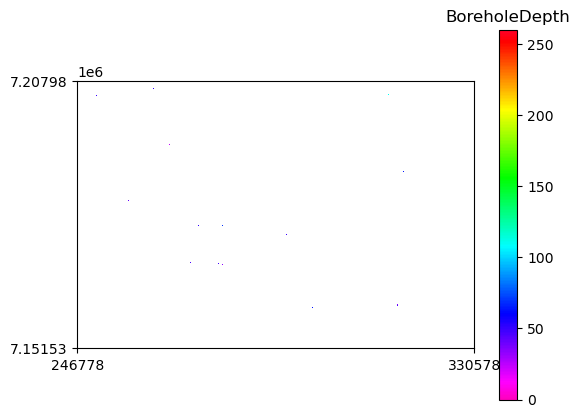

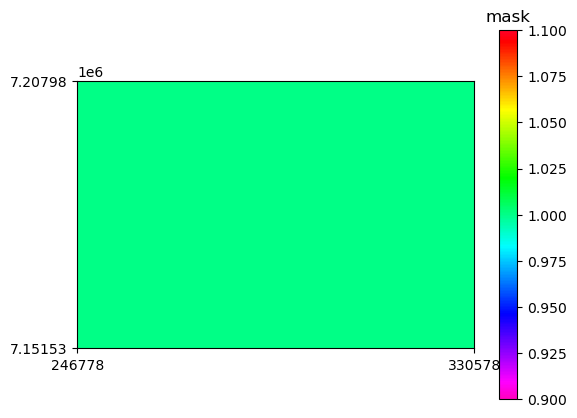

In [48]:
import matplotlib.pyplot as plt

BoreholeDepth=readmap("boreholedepth.map") #FF
mask = readmap("clone.map")
mask = scalar(mask)
plot(BoreholeDepth) #from pc raster 
plot(mask)

#Overlay Borehole on top of the mask
#to be checked



Visualise `BoreholeDepth` with Aguila. Bacause we run this Jupyter Notebook locally, we can use the `aguila` python operation. The map will popup in the background, so you might need to look for it.

In [ ]:
aguila(BoreholeDepth)

## 3. Interpolate borehole depth with IDW
We can now interpolate the borehole depth at the pixels. We'll first apply the Inverse Distance Weighting method. This has been implemented as the [inversedistance operation](https://pcraster.geo.uu.nl/pcraster/4.3.0/documentation/pcraster_manual/sphinx/op_inversedistance.html) in PCRaster.

The syntax is: 
```Python
Result = inversedistance( mask, points, idp, radius, maxNr)
```

Where 
* <code>mask</code> is a mask of the extent that will be interpolated. In our case we'll use the clone map. 
* <code>points</code> is the scalar raster layer with pixels that you want to interpolate. In our case <code>BoreholeDepth</code>.
* <code>idp</code> is the exponent of the power function for the weights. An <code>idp</code> value of 2 is commonly used.
* <code>radius</code> indicates the distance to a cell within it has to take interpolation points into account. If it's set to 0 there's no limitation.
* <code>maxNr</code> limits the number of points used for the interpolation. If it's set to 0 there's no maximum.

Let's first read the clone map that we'll use as the mask.

In [32]:
Mask = readmap("clone.map")

Now we interpolate the borehole depths with IDW using the following line:

In [33]:
BoreholeDepthIDW = inversedistance( Mask, BoreholeDepth, 2, 0, 0)

Let's visualise the result with Aguila.

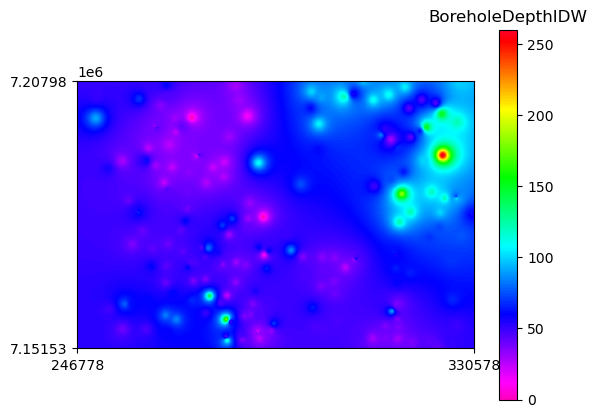

/mnt/c/Users/felip/OneDrive - Universidad Nacional de Colombia/2_Formation/DataSc/2_SpatialDS/3_PrGeoHydApp/1_IHEpy4hydroapp/3_MapAlPcrtut/2_GroundwaterInterpolation/Data


In [72]:
plot(BoreholeDepthIDW)
print(os.getcwd())
report(BoreholeDepthIDW,"fboreholeDepthIDW.map")

## 4. Interpolate borehole depth with Thiessen polygons
Another interpolation method is using so called Thiessen polygons.

In PCRaster this involves three steps:
1. Assign a unique ID to each borehole
2. Assign to each pixel the closest borehole ID
3. Assign the borehole depth to the corresponding borehole IDs for all cells

Let's first assign a unique ID to each borehole using the <code>uniqueid</code> operation. The input needs to be a boolean raster.

To create a boolean raster of the boreholes we use the <code>defined</code> operation. This will give boolean True for all cells with a value and boolean False for all nodata cells.

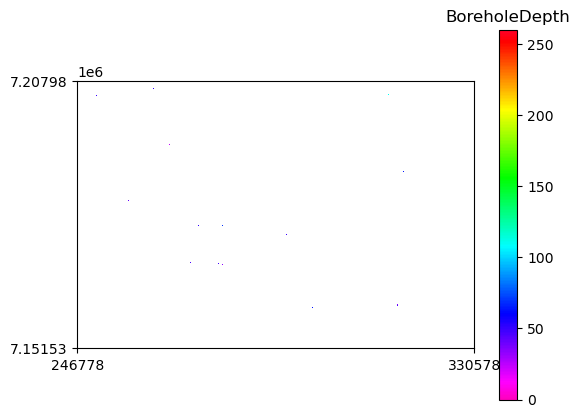

In [54]:
plot(BoreholeDepth)
Boreholes = defined(BoreholeDepth) #to make boolean

Check the result with Aguila.

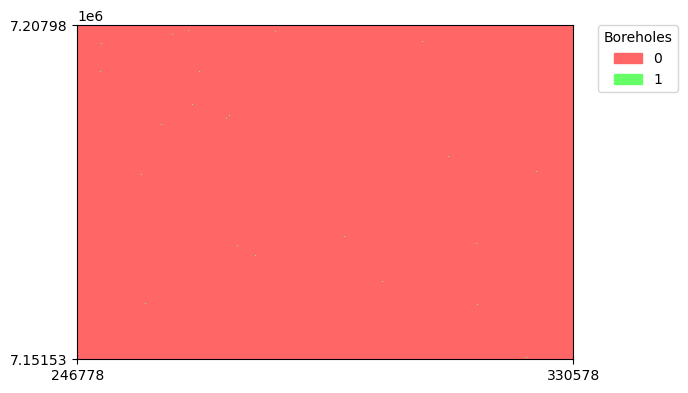

In [52]:
plot(Boreholes)
aguila(Boreholes)

Now we assign a unique ID to each boolean True cell. Note that we want the output to be nominal instead of scalar. Therefore we wrap the <code>uniqueid</code> into the <code>nominal</code> operation.

In [55]:
BoreholeID = nominal(uniqueid(Boreholes))

Check the result with Aguila.

In [70]:
aguila(BoreholeID)

Let's assign to each cell its closes borehole ID. We use the <code>spreadzone</code> operation, which has the following syntax:

<code>Result = spreadzone(points, initialfrictiondist, friction)</code>

Where:

* <code>points</code> is the raster with points to interpolate. In our case BoreholeID.
* <code>initialfrictiondist</code> is the initial friction distance. We don't need that, so we make it 0.
* <code>friction</code> is the friction for each cell, which we keep constant at 1.

In [58]:
ThiessenID = spreadzone(BoreholeID,0,1)

Check the result with Aguila.

In [71]:
aguila(ThiessenID)

The final step is to assign the groundwater depth values of the boreholes to the Thiessen polygons.
We can do that by calculating the minimum or maximum depth per class, which will just extrapolate the value to the whole class. Here we'll use <code>areamaximum</code>:

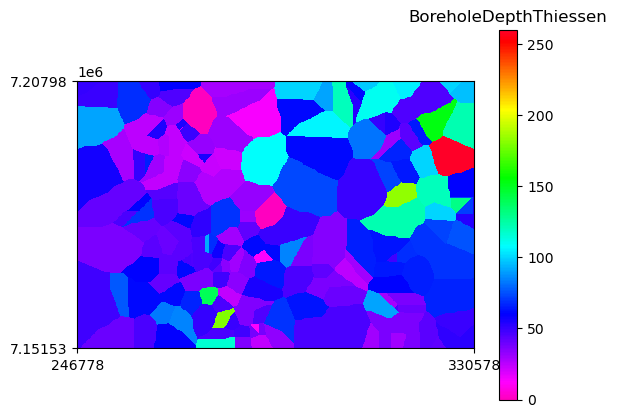

In [65]:
BoreholeDepthThiessen = areamaximum(BoreholeDepth,ThiessenID)
plot(BoreholeDepthThiessen)


Check the result and compare it with the IDW interpolation using Aguila.

In [64]:
aguila(BoreholeDepthIDW,BoreholeDepthThiessen, Boreholes)

Can you write a script that calculates Thiessen polygons? Make a function that can be applied to similar data as the `BoreholeDepth` raster.

*By __[Hans van der Kwast](http://www.linkedin.com/in/jvdkwast)__*<br>
*__[IHE Delft Institute for Water Education](http://www.un-ihe.org)__*<br>
*Twitter: @hansakwast*

*These materials are OpenCourseWare, licensed as [CC By-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/)*